
# AC-06 Customer Segmentation for Personalized Retail Marketing

List anggota :
1. (M232D5Y1519) - (Noor Ahmad Maula)- (Machine Learning)
2. (M232D5Y0389) - (Christian Moses Gonzales Para’pa)- (Machine Learning)
3. (M232D5Y1211) - (Muhammad Ali Ma’ruf)- (Machine Learning)


## 0. Workflow Analisis

1. Import library  
2. Loading dataset  
3. Audit data & cleaning  
4. Konstruksi tabel RFM  
5. Transformasi & penanganan outlier  
6. Klustering + uji K  
7. Bandingkan alternatif model klaster  
8. Insight singkat


In [1]:
try:
    import yellowbrick
except ImportError:
    !pip -q install yellowbrick


# **1. Import Library**

Pada tahap ini dilakukan pemanggilan pustaka (*library*) Pyhton yang dibutuhkan untuk *loading data*, analisis data, pembangunan model *machine learning*.

In [2]:
from google.colab import files
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture

from yellowbrick.cluster import KElbowVisualizer
from pathlib import Path
from scipy.stats import norm


plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

# **2. Loading Dataset & Audit Awal**

Pada tahap Loading Dataset & Audit Awal akan dilakukan berbagai hal berikut:
1. Memanggil dataset pada google drive
2. Menampilkan 5 baris pertama dataset
3. Meninjau jumlah baris kolom dan jenis data pada dataset sebelum dibersihkan
4. Menampilkan statistik deskriptif sebelum dibersihkan

## 2.1. Load Data dari Drive

In [3]:
file_id = "1X15HniOUYoP79VnMCa38q5zoJNwrNslG"
url = f"https://drive.google.com/uc?id={file_id}"

## 2.2. Tampilkan 5 Dataset awal

In [4]:
raw_df = pd.read_csv(url)
print("Shape awal:", raw_df.shape)
raw_df.head()

Shape awal: (1067371, 8)


Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

## 2.3. Audit Awal Dataset

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


## 2.4. Statistik Deskriptif

In [6]:
raw_df.describe(include="all").T

count unique                                 top    freq  \
Invoice        1067371  53628                              537434    1350   
StockCode      1067371   5305                              85123A    5829   
Description    1062989   5698  WHITE HANGING HEART T-LIGHT HOLDER    5918   
Quantity     1067371.0    NaN                                 NaN     NaN   
InvoiceDate    1067371  47635                 2010-12-06 16:57:00    1350   
Price        1067371.0    NaN                                 NaN     NaN   
Customer ID   824364.0    NaN                                 NaN     NaN   
Country        1067371     43                      United Kingdom  981330   

                     mean         std       min      25%      50%      75%  \
Invoice               NaN         NaN       NaN      NaN      NaN      NaN   
StockCode             NaN         NaN       NaN      NaN      NaN      NaN   
Description           NaN         NaN       NaN      NaN      NaN      NaN   
Quantity         9.938898  172.705794  -80995.0      1.0      3.0     10.0   
InvoiceDate           NaN         NaN       NaN      NaN      NaN      NaN   
Price            4.649388  123.553059 -53594.36     1.25      2.1     4.15   
Customer ID  15324.638504  1697.46445   12346.0  13975.0  15255.0  16797.0   
Country               NaN         NaN       NaN      NaN      NaN      NaN   

                 max  
Invoice          NaN  
StockCode        NaN  
Description      NaN  
Quantity     80995.0  
InvoiceDate      NaN  
Price        38970.0  
Customer ID  18287.0  
Country          NaN


# **3. Data Cleaning**

Pada tahap Data Cleaning akan dilakukan berbagai hal berikut:
1. Ubah tipe data tanggal  
2. Tangani missing value  
3. Buang transaksi cancel
4. Buang duplikat  
5. Hitung `Total Amount`


In [7]:
df = raw_df.copy()

## 3.1 Ubah tipe data tanggal

In [8]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

## 3.2 Cek missing value

In [9]:
print("Missing value per kolom:")
print(df.isnull().sum())

df = df.dropna(subset=["Customer ID"])
df["Customer ID"] = df["Customer ID"].astype(int)

Missing value per kolom:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


## 3.3 Buang invoice yang melakukan cancel (diawali huruf "C")

In [10]:
mask_cancel = df["Invoice"].astype("string").str.startswith("C", na=False)

print("Jumlah transaksi cancel:", int(mask_cancel.sum()))
df = df.loc[~mask_cancel].copy()

Jumlah transaksi cancel: 18744


## 3.4 Buang duplikat

In [11]:
print("Jumlah duplikat sebelum dihapus:", df.duplicated().sum())
df = df.drop_duplicates()
print("Jumlah duplikat setelah dihapus:", df.duplicated().sum())

Jumlah duplikat sebelum dihapus: 26125
Jumlah duplikat setelah dihapus: 0


## 3.5 Hitung total belanja per baris

In [12]:
for col in ["Quantity", "Price"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["Quantity","Price"])
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]
df["Total Amount"] = df["Quantity"] * df["Price"]

print("Shape setelah cleaning:", df.shape)

Shape setelah cleaning: (779425, 9)


# **4. Exploratory Data Analysis (EDA)**

Pada tahap Exploratory Data Analysis (EDA) akan dilakukan berbagai hal berikut:
1. Menampilkan 5 baris pertama pada dataset
2. Menampikan jumlah baris dan kolom data
3. Melakukan cek tipe data pada data
4. Menampikan statistik deskriptif pada data

In [13]:
df_eda = df.copy()

## 4.1. Menampilkan 5 baris pertama dataset

In [14]:
df_eda.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Total Amount  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom          83.4  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom          81.0  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom          81.0  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom         100.8  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom          30.0

## 4.2. Menampilkan dimensi dataset

In [15]:
print('Shape of Dataset: ', df_eda.shape)

Shape of Dataset:  (779425, 9)


## 4.3. Melakukan cek tipe data

In [16]:
df_eda.dtypes

Invoice                 object
StockCode               object
Description             object
Quantity                 int64
InvoiceDate     datetime64[ns]
Price                  float64
Customer ID              int64
Country                 object
Total Amount           float64
dtype: object

# 4.4. Menampilkan statistik deskriptif

In [17]:
df_eda.describe()

Quantity                    InvoiceDate          Price  \
count  779425.000000                         779425  779425.000000   
mean       13.489370  2011-01-03 01:44:42.593475584       3.218488   
min         1.000000            2009-12-01 07:45:00       0.001000   
25%         2.000000            2010-07-02 14:39:00       1.250000   
50%         6.000000            2010-12-02 14:09:00       1.950000   
75%        12.000000            2011-08-01 13:44:00       3.750000   
max     80995.000000            2011-12-09 12:50:00   10953.500000   
std       145.855814                            NaN      29.676140   

         Customer ID   Total Amount  
count  779425.000000  779425.000000  
mean    15320.360461      22.291823  
min     12346.000000       0.001000  
25%     13971.000000       4.950000  
50%     15247.000000      12.480000  
75%     16794.000000      19.800000  
max     18287.000000  168469.600000  
std      1695.692775     227.427075


# **5. Konstruksi Fitur RFM**

Pada tahap Konstruksi Fitur RFM akan dilakukan berbagai hal berikut:
1. Tanggal Referensi untuk Recency
2. Agregasi R F M per Customer
3. Validasi & Perapihan Tabel RFM
4. Visualisasi Distribusi R, F, M

## 5.1 Tanggal Referensi untuk Recency

In [18]:
reference_date = df["InvoiceDate"].max() + timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:50:00')

## 5.2 Agregasi R F M per Customer

In [19]:
rfm = (
    df.groupby("Customer ID").agg(
        LastInvoice=("InvoiceDate", "max"),
        Frequency=("Invoice", "nunique"),
        Monetary=("Total Amount", "sum"),
    )
    .reset_index()
)

# hitung Recency (hari) lalu rapikan kolom
rfm["Recency"] = (reference_date - rfm["LastInvoice"]).dt.days.astype(int)
rfm = rfm[["Customer ID", "Recency", "Frequency", "Monetary"]]

rfm.head()

Customer ID  Recency  Frequency  Monetary
0        12346      326         12  77556.46
1        12347        2          8   4921.53
2        12348       75          5   2019.40
3        12349       19          4   4428.69
4        12350      310          1    334.40

## 5.3 Validasi & Perapihan Tabel RFM

In [20]:
rfm = rfm[(rfm["Frequency"] > 0) & (rfm["Monetary"] > 0)].copy()
rfm = rfm.sort_values("Customer ID").reset_index(drop=True)

print("Shape RFM:", rfm.shape)
display(rfm.describe())

Shape RFM: (5878, 4)


Customer ID      Recency    Frequency       Monetary
count   5878.000000  5878.000000  5878.000000    5878.000000
mean   15315.313542   201.331916     6.289384    2955.904095
std     1715.572666   209.338707    13.009406   14440.852688
min    12346.000000     1.000000     1.000000       2.950000
25%    13833.250000    26.000000     1.000000     342.280000
50%    15314.500000    96.000000     3.000000     867.740000
75%    16797.750000   380.000000     7.000000    2248.305000
max    18287.000000   739.000000   398.000000  580987.040000

## 5.4. Visualisasi Distribusi R, F, M

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.histplot(rfm["Recency"],   bins=40, ax=axes[0]); axes[0].set_title("Distribusi Recency")
sns.histplot(rfm["Frequency"], bins=40, ax=axes[1]); axes[1].set_title("Distribusi Frequency")
sns.histplot(rfm["Monetary"],  bins=40, ax=axes[2]); axes[2].set_title("Distribusi Monetary")
plt.tight_layout()
plt.show()


# **6. Transformasi & Penanganan Outlier**

Pada tahap Transformasi & Penanganan Outlier akan dilakukan berbagai hal berikut:
1. Definisi util IQR untuk buang outlier
2. Terapkan IQR pada R, F, M
3. Transformasi log untuk F & M + siapkan fitur
4. Standardisasi (scaling)


## 6.1 Definisi util IQR untuk buang outlier

In [22]:
def remove_outliers_iqr(df_in, cols):
    df_out = df_in.copy()
    for col in cols:
        q1, q3 = np.percentile(df_out[col], [25, 75])
        iqr = q3 - q1
        low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df_out = df_out[(df_out[col] >= low) & (df_out[col] <= high)]
    return df_out

## 6.2 Terapkan IQR pada R, F, M

In [23]:
print("Shape RFM sebelum outlier:", rfm.shape)
rfm_clean = remove_outliers_iqr(rfm, ["Recency", "Frequency", "Monetary"]).reset_index(drop=True)
print("Shape RFM setelah outlier :", rfm_clean.shape)

rfm_clean = rfm_clean[(rfm_clean["Frequency"] > 0) & (rfm_clean["Monetary"] > 0)].copy()

Shape RFM sebelum outlier: (5878, 4)
Shape RFM setelah outlier : (5001, 4)


## 6.3 Transformasi log untuk F & M + siapkan fitur

In [24]:
rfm_features = rfm_clean.copy()
rfm_features["Frequency_log"] = np.log1p(rfm_features["Frequency"])
rfm_features["Monetary_log"]  = np.log1p(rfm_features["Monetary"])

# matriks fitur untuk clustering
X = rfm_features[["Recency", "Frequency_log", "Monetary_log"]]
X.head()

Recency  Frequency_log  Monetary_log
0       75       1.791759      7.611051
1      310       0.693147      5.815324
2      375       0.693147      5.710195
3       36       2.397895      7.955369
4      204       1.098612      6.010679

## 6.4 Standardisasi (scaling)

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Mean ~0:", np.round(X_scaled.mean(axis=0), 4))
print("Std  ~1:", np.round(X_scaled.std(axis=0, ddof=0), 4))

Mean ~0: [ 0.  0. -0.]
Std  ~1: [1. 1. 1.]


## 6.5 Analisa antar fitur & fitur turunan"

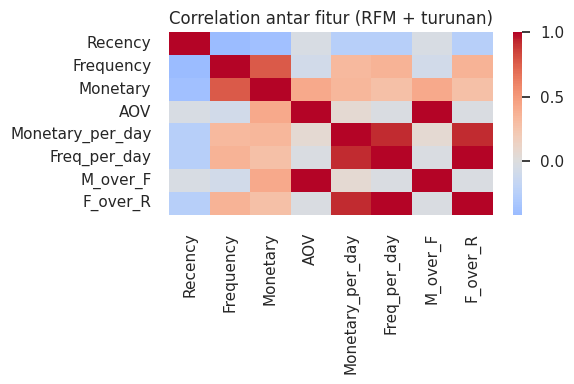

In [26]:
# Fitur turunan sederhana dari tabel RFM
rfm_features["AOV"] = rfm_features["Monetary"] / rfm_features["Frequency"]
rfm_features["Monetary_per_day"] = rfm_features["Monetary"] / rfm_features["Recency"].clip(lower=1)
rfm_features["Freq_per_day"] = rfm_features["Frequency"] / rfm_features["Recency"].clip(lower=1)
rfm_features["M_over_F"] = rfm_features["Monetary"] / rfm_features["Frequency"].replace(0, np.nan)
rfm_features["F_over_R"] = rfm_features["Frequency"] / rfm_features["Recency"].clip(lower=1)

# Korelasi cepat untuk melihat relasi antar fitur
feat_for_corr = rfm_features[[
    "Recency","Frequency","Monetary","AOV","Monetary_per_day","Freq_per_day","M_over_F","F_over_R"
]]
corr = feat_for_corr.corr(numeric_only=True)

plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation antar fitur (RFM + turunan)")
plt.tight_layout(); plt.show()

# Matriks fitur plus
X_plus = rfm_features[["Recency","Frequency_log","Monetary_log","AOV","F_over_R"]].fillna(0)
X_plus_scaled = StandardScaler().fit_transform(X_plus)


# **7. Klustering K-Means & Uji K**

Pada tahap Klustering K-Means & Uji K akan dilakukan berbagai hal berikut:
1. Elbow Method (Distortion/SSE)
2. Sweep Silhouette Score untuk beberapa k
3. Pilih k terbaik & fit model utama
4. Ringkasan jumlah anggota cluster
5. Visualisasi sebaran (Recency vs Monetary)


## 7.1. Elbow Method (Distortion/SSE)

In [27]:
_elbow_model = KMeans(random_state=42, n_init=10)
elbow_viz = KElbowVisualizer(_elbow_model, k=(2, 10), timings=True)
elbow_viz.fit(X_scaled)
elbow_viz.show();

best_k_elbow = getattr(elbow_viz, "elbow_value_", None)
print("Jumlah cluster (elbow):", best_k_elbow)

Jumlah cluster (elbow): 5


## 7.2 Sweep Silhouette Score untuk beberapa k

In [28]:
sil_scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil
    print(f"k = {k}, silhouette = {sil:.4f}")

best_k_sil = max(sil_scores, key=sil_scores.get)
print("\nJumlah cluster terbaik menurut silhouette:", best_k_sil)


k = 2, silhouette = 0.4166
k = 3, silhouette = 0.3779
k = 4, silhouette = 0.3857
k = 5, silhouette = 0.3569
k = 6, silhouette = 0.3433
k = 7, silhouette = 0.3077
k = 8, silhouette = 0.3097
k = 9, silhouette = 0.3050

Jumlah cluster terbaik menurut silhouette: 2


## 7.3. Pilih k terbaik & fit model utama

In [29]:
best_k = best_k_sil if best_k_sil is not None else (best_k_elbow or 2)

kmeans_main = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm_features["cluster_main"] = kmeans_main.fit_predict(X_scaled)

print("k final:", best_k)
display(
    rfm_features
      .groupby("cluster_main")[["Recency","Frequency","Monetary"]]
      .mean().round(2)
)

k final: 2


Recency  Frequency  Monetary
cluster_main                              
0              103.39       5.45   1610.02
1              350.91       1.48    373.71

## 7.4 Ringkasan jumlah anggota cluster

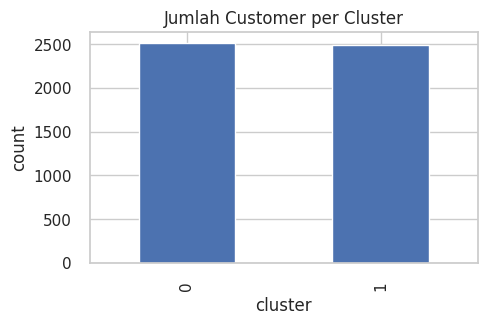

In [30]:
ax = (
    rfm_features["cluster_main"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", figsize=(5,3))
)
ax.set_title("Jumlah Customer per Cluster")
ax.set_xlabel("cluster")
ax.set_ylabel("count")
plt.show()

## 7.5 Visualisasi sebaran (Recency vs Monetary)

In [31]:
plt.figure(figsize=(6,5))
plt.scatter(
    rfm_features["Recency"],
    rfm_features["Monetary"],
    c=rfm_features["cluster_main"],
    alpha=0.6
)
plt.xlabel("Recency (hari)")
plt.ylabel("Monetary (total belanja)")
plt.title("Cluster utama berdasarkan RFM")
plt.show()

## 7.6 Model alternatif (GMM / Agglomerative / DBSCAN) + komparasi

In [32]:
results_alt = []

# 1) Gaussian Mixture Model (pakai X_scaled)
best = {"model":"GMM","k":None,"score":-1,"labels":None}
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    if len(np.unique(labels)) < 2:
        continue
    sil = silhouette_score(X_scaled, labels)
    if sil > best["score"]:
        best.update({"k": k, "score": sil, "labels": labels})
results_alt.append(best)

# 2) Agglomerative (Ward) — tanpa asumsi bentuk cluster bulat
best = {"model":"Agglomerative","k":None,"score":-1,"labels":None}
for k in range(2, 9):
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    if sil > best["score"]:
        best.update({"k": k, "score": sil, "labels": labels})
results_alt.append(best)

# 3) DBSCAN — cari eps/min_samples terbaik (abaikan noise saat hitung silhouette)
best = {"model":"DBSCAN","k":"var","score":-1,"labels":None,"eps":None,"min_samples":None}
for eps in np.linspace(0.3, 1.5, 7):
    for ms in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        ncl = len(set(labels)) - (1 if -1 in labels else 0)
        if ncl < 2:
            continue
        mask = labels != -1
        sil = silhouette_score(X_scaled[mask], labels[mask])
        if sil > best["score"]:
            best.update({"score": sil, "labels": labels, "eps": round(eps, 2), "min_samples": ms})
results_alt.append(best)

# Ringkas + bandingkan dengan KMeans yang sudah kamu hitung (sil_scores & best_k)
kmeans_sil = float(max(sil_scores.values()))
summary = pd.DataFrame(
    [{"model":"KMeans","k":int(best_k),"score":kmeans_sil}] +
    [{"model":r["model"],"k":r["k"],"score":float(r["score"])} for r in results_alt]
).sort_values("score", ascending=False)
print(summary)

# Pilih pemenang
winner = max(results_alt, key=lambda d: d["score"])
if winner["score"] > kmeans_sil:
    rfm_features["cluster_main_alt"] = winner["labels"]
    print(f"Model alternatif terbaik: {winner['model']} | score={winner['score']:.3f} | k={winner['k']}")
else:
    rfm_features["cluster_main_alt"] = rfm_features["cluster_main"]
    print("KMeans tetap terbaik menurut silhouette.")

# Visual sebaran versi model pemenang
plt.figure(figsize=(6,5))
plt.scatter(
    rfm_features["Recency"],
    rfm_features["Monetary"],
    c=rfm_features["cluster_main_alt"],
    alpha=0.6
)
plt.xlabel("Recency (hari)"); plt.ylabel("Monetary (total belanja)")
plt.title("Sebaran cluster (model terbaik per perbandingan)")
plt.tight_layout(); plt.show()

           model    k     score
0         KMeans    2  0.416602
3         DBSCAN  var  0.347731
2  Agglomerative    2  0.344876
1            GMM    2  0.274366
KMeans tetap terbaik menurut silhouette.



# **8. Bandingkan Alternatif Model Klaster**

Pada tahap Bandingkan Alternatif Model Klaster akan dilakukan berbagai hal berikut:
1. Skor Diskrit RFM (quantile 25/50/75)
2. Bangun tabel alternatif (R_Score, F_Score, M_Score, Segment, Score)
3. Uji K (Silhouette) pada skor diskrit RFM
4. Fit model alternatif & ringkasan cluster
5. Ringkas perbandingan (main vs alt)


## 8.1 Skor Diskrit RFM (quantile 25/50/75)

In [33]:
quantiles = rfm_clean[["Recency","Frequency","Monetary"]].quantile(q=[0.25,0.50,0.75])

def rfm_score(x, col, q):
    if col=="Recency":  # makin kecil makin baik
        return 4 if x<=q[col].loc[0.25] else 3 if x<=q[col].loc[0.50] else 2 if x<=q[col].loc[0.75] else 1
    else:               # Frequency & Monetary makin besar makin baik
        return 1 if x<=q[col].loc[0.25] else 2 if x<=q[col].loc[0.50] else 3 if x<=q[col].loc[0.75] else 4

## 8.2 Bangun tabel alternatif (R_Score, F_Score, M_Score, Segment, Score)

In [34]:
rfm_alt = rfm_clean.copy()
rfm_alt["R_Score"] = rfm_alt["Recency"].apply(rfm_score, args=("Recency", quantiles)).astype(int)
rfm_alt["F_Score"] = rfm_alt["Frequency"].apply(rfm_score, args=("Frequency", quantiles)).astype(int)
rfm_alt["M_Score"] = rfm_alt["Monetary"].apply(rfm_score, args=("Monetary", quantiles)).astype(int)

rfm_alt["RFM_Segment"] = (
    rfm_alt["R_Score"].astype(str)+rfm_alt["F_Score"].astype(str)+rfm_alt["M_Score"].astype(str)
)
rfm_alt["RFM_Score"] = rfm_alt[["R_Score","F_Score","M_Score"]].sum(axis=1).astype(int)

display(rfm_alt.head())

Customer ID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0        12348       75          5   2019.40        3        3        4   
1        12350      310          1    334.40        2        1        2   
2        12351      375          1    300.93        2        1        1   
3        12352       36         10   2849.84        4        4        4   
4        12353      204          2    406.76        2        2        2   

  RFM_Segment  RFM_Score  
0         334         10  
1         212          5  
2         211          4  
3         444         12  
4         222          6

## 8.3 Uji K (Silhouette) pada skor diskrit RFM

In [35]:
X_alt = rfm_alt[["R_Score","F_Score","M_Score"]]
X_alt_scaled = StandardScaler().fit_transform(X_alt)

sil_scores_alt = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(X_alt_scaled)
    sil = silhouette_score(X_alt_scaled, lbl)
    sil_scores_alt[k] = sil
    print(f"[ALT] k={k}  silhouette={sil:.4f}")

best_k_alt = max(sil_scores_alt, key=sil_scores_alt.get)
print("\nJumlah cluster terbaik (alt):", best_k_alt)

[ALT] k=2  silhouette=0.4489
[ALT] k=3  silhouette=0.4028
[ALT] k=4  silhouette=0.4233
[ALT] k=5  silhouette=0.4103
[ALT] k=6  silhouette=0.3996
[ALT] k=7  silhouette=0.4088

Jumlah cluster terbaik (alt): 2


## 8.4 Fit model alternatif & ringkasan cluster

In [36]:
kmeans_alt = KMeans(n_clusters=best_k_alt, random_state=42, n_init=10)
rfm_alt["cluster_alt"] = kmeans_alt.fit_predict(X_alt_scaled)

alt_summary = (
    rfm_alt.groupby("cluster_alt")[["Recency","Frequency","Monetary","RFM_Score"]]
           .mean().round(2)
           .reset_index()
)
display(alt_summary)

cluster_alt  Recency  Frequency  Monetary  RFM_Score
0            0   344.73       1.47    360.40       4.91
1            1   112.73       5.41   1605.84       9.73

## 8.5 Ringkas perbandingan (main vs alt)

Model utama (fitur kontinu): {2: 0.41660170254262585, 3: 0.3778866992301469, 4: 0.3856604316187776, 5: 0.35691589109321514, 6: 0.3432716974053127, 7: 0.30770667389605394, 8: 0.3097212768005133, 9: 0.3050035363080193}
Model alternatif (skor RFM): {2: 0.4488831550822041, 3: 0.4027893852412292, 4: 0.42327924500578046, 5: 0.410267346767856, 6: 0.3996397223216101, 7: 0.4088083642793171}


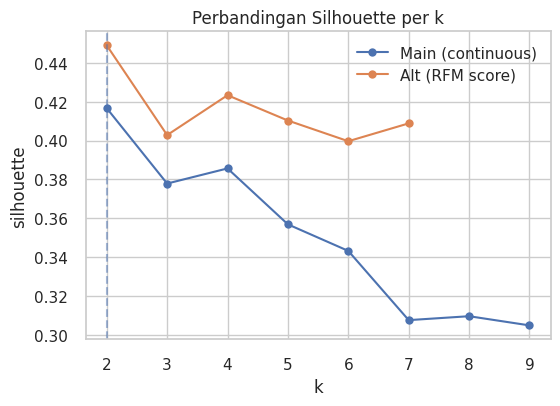

In [37]:
print("Model utama (fitur kontinu):", {k: float(v) for k,v in sil_scores.items()})
print("Model alternatif (skor RFM):", {k: float(v) for k,v in sil_scores_alt.items()})

plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o", label="Main (continuous)")
plt.plot(list(sil_scores_alt.keys()), list(sil_scores_alt.values()), marker="o", label="Alt (RFM score)")
plt.axvline(best_k_alt, ls="--", alpha=0.5)
plt.title("Perbandingan Silhouette per k")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.legend(); plt.show()

# **9. Validasi Temporal (Train vs OOT)**

## 9.1 Split waktu: Train vs OOT (90 hari terakhir)

In [38]:
cut_date = df["InvoiceDate"].max() - pd.Timedelta(days=90)
ref_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

df_train = df[df["InvoiceDate"] <= cut_date].copy()
df_oot   = df[df["InvoiceDate"] >  cut_date].copy()

print("Range train s.d:", cut_date.date(), "| OOT mulai:", (cut_date+pd.Timedelta(days=1)).date())
print("n transaksi train:", len(df_train), "| n transaksi OOT:", len(df_oot))


Range train s.d: 2011-09-10 | OOT mulai: 2011-09-11
n transaksi train: 620572 | n transaksi OOT: 158853


## 9.2 Bangun fitur RFM untuk Train & OOT

In [39]:
def build_rfm_features(df_in, ref_date):
    rfm_tmp = df_in.groupby("Customer ID").agg(
        Recency=("InvoiceDate", lambda x: (ref_date - x.max()).days),
        Frequency=("Invoice","nunique"),
        Monetary=("Total Amount","sum")
    )
    rfm_tmp["Frequency_log"] = np.log1p(rfm_tmp["Frequency"])
    rfm_tmp["Monetary_log"]  = np.log1p(rfm_tmp["Monetary"])
    X_tmp = rfm_tmp[["Recency","Frequency_log","Monetary_log"]]
    return rfm_tmp, X_tmp

rfm_train, X_tr_raw = build_rfm_features(df_train, ref_date)
rfm_oot,   X_o_raw  = build_rfm_features(df_oot,   ref_date)

print("n customer train:", len(rfm_train), "| n customer OOT:", len(rfm_oot))

n customer train: 5281 | n customer OOT: 2889


# 9.3 Scaling: fit di Train, apply ke OOT

In [40]:
scaler_t = StandardScaler().fit(X_tr_raw)
X_tr  = scaler_t.transform(X_tr_raw)
X_oot = scaler_t.transform(X_o_raw)

## 9.4 Fit cluster di Train, mapping OOT via 1-NN ke centroid

In [41]:
kmeans_t = KMeans(n_clusters=int(best_k), random_state=42, n_init=10).fit(X_tr)
lab_tr = kmeans_t.labels_

knn = KNeighborsClassifier(n_neighbors=1).fit(kmeans_t.cluster_centers_, np.arange(int(best_k)))
lab_oot = knn.predict(X_oot)

sil_tr = silhouette_score(X_tr,  lab_tr) if len(np.unique(lab_tr)) > 1 else np.nan
sil_o  = silhouette_score(X_oot, lab_oot) if len(np.unique(lab_oot)) > 1 else np.nan

try:
    centroid_shift = float(np.linalg.norm(kmeans_main.cluster_centers_ - kmeans_t.cluster_centers_))
except Exception:
    centroid_shift = np.nan

## 9.5 Ringkasan & visual singkat

Temporal validation: {'cut_date': '2011-09-10', 'silhouette_train': 0.4266241505831769, 'silhouette_oot': 0.4676447065741339, 'n_customers_train': 5281, 'n_customers_oot': 2889, 'centroid_shift_L2_vs_global': 3.509801711949298}


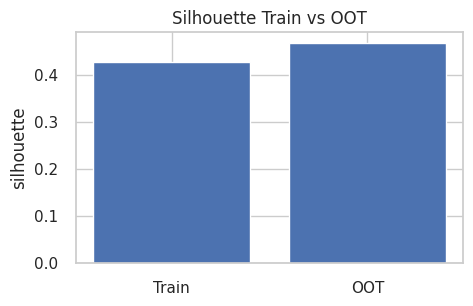

In [42]:
temporal_report = {
    "cut_date": str(cut_date.date()),
    "silhouette_train": float(sil_tr),
    "silhouette_oot": float(sil_o),
    "n_customers_train": int(len(rfm_train)),
    "n_customers_oot": int(len(rfm_oot)),
    "centroid_shift_L2_vs_global": centroid_shift
}
print("Temporal validation:", temporal_report)

plt.figure(figsize=(5,3))
plt.bar(["Train","OOT"], [sil_tr, sil_o])
plt.title("Silhouette Train vs OOT")
plt.ylabel("silhouette")
plt.show()

# **10. Persona & Insight**

## 10.1. Label persona + ringkasan angka

In [43]:
X_all = rfm_features[["Recency","Frequency_log","Monetary_log"]]
try:
    X_all_s = scaler.transform(X_all)
except Exception:
    scaler = StandardScaler().fit(X_all)
    X_all_s = scaler.transform(X_all)

rfm_features[["Recency_s","Frequency_log_s","Monetary_log_s"]] = X_all_s

def persona_rule(r):
    if r["Frequency_log_s"] > 0.5 and r["Monetary_log_s"] > 0.5 and r["Recency_s"] < -0.3:
        return "Active Value"
    if r["Recency_s"] > 0.7:
        return "Dormant"
    return "Regular"

rfm_features["persona"] = rfm_features.apply(persona_rule, axis=1)

cluster_summary = (
    rfm_features
      .groupby(["cluster_main","persona"])
      [["Recency","Frequency","Monetary"]]
      .mean().round(2)
      .reset_index()
)
display(cluster_summary)

cluster_main       persona  Recency  Frequency  Monetary
0             0  Active Value    44.51       7.57   2249.74
1             0       Dormant   434.11       4.96   1685.94
2             0       Regular   108.88       3.80   1080.52
3             1       Dormant   518.96       1.49    400.71
4             1       Regular   159.43       1.46    342.94

## 10.2. Visual ringkas

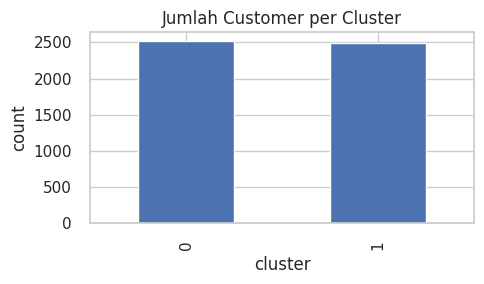

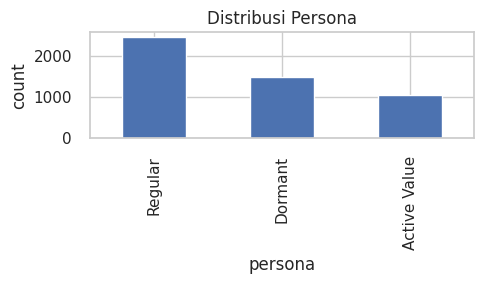

In [44]:
plt.figure(figsize=(5,3))
(rfm_features["cluster_main"].value_counts().sort_index()
 .plot(kind="bar"))
plt.title("Jumlah Customer per Cluster")
plt.xlabel("cluster"); plt.ylabel("count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3))
(rfm_features["persona"].value_counts()
 .plot(kind="bar"))
plt.title("Distribusi Persona")
plt.xlabel("persona"); plt.ylabel("count")
plt.tight_layout(); plt.show()

## 11. Rekomendasi Aksi

## 11.1. Mapping aksi per persona

In [45]:
action_map = {
    "Active Value": "Loyalty tier + early access + bundling kategori favorit",
    "Regular":      "Promo ringan personalisasi + rekomendasi produk relevan",
    "Dormant":      "Win-back voucher + email reaktivasi bertahap"
}
rfm_features["recommendation"] = rfm_features["persona"].map(action_map)

rec_examples = (
    rfm_features
      .groupby("persona", as_index=False)["recommendation"]
      .first()
)
display(rec_examples)

persona                                     recommendation
0  Active Value  Loyalty tier + early access + bundling kategor...
1       Dormant       Win-back voucher + email reaktivasi bertahap
2       Regular  Promo ringan personalisasi + rekomendasi produ...

## 11.2. Preview calon target kampanye

In [46]:
preview_targets = (
    rfm_features
      .groupby("persona", group_keys=False)
      .apply(lambda d: d.sample(min(10, len(d)), random_state=42))
      [["Customer ID","Recency","Frequency","Monetary","cluster_main","persona","recommendation"]]
      .reset_index(drop=True)
)
display(preview_targets.head(20))

/tmp/ipython-input-866044857.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.sample(min(10, len(d)), random_state=42))


Customer ID  Recency  Frequency  Monetary  cluster_main       persona  \
0         14640       24         10   3649.36             0  Active Value   
1         13037      138         12   3914.95             0  Active Value   
2         17667       66          9   3950.70             0  Active Value   
3         18277       58          5   1180.05             0  Active Value   
4         12728       71          5   1070.17             0  Active Value   
5         14293        3          9   2903.01             0  Active Value   
6         13946       79          6   1876.23             0  Active Value   
7         14409       71          9   3427.29             0  Active Value   
8         17075       18         10   2236.63             0  Active Value   
9         13285       23          6   3364.59             0  Active Value   
10        16155      382          5    796.90             0       Dormant   
11        13608      541          1    232.05             1       Dormant   
12        13511      677          1    282.76             1       Dormant   
13        15487      680          1    231.32             1       Dormant   
14        14086      463          1     39.95             1       Dormant   
15        16731      648          1    170.30             1       Dormant   
16        14119      376          2    183.37             1       Dormant   
17        17922      543          1    170.40             1       Dormant   
18        13346      463          6    299.40             1       Dormant   
19        18286      477          2   1296.43             1       Dormant   

                                       recommendation  
0   Loyalty tier + early access + bundling kategor...  
1   Loyalty tier + early access + bundling kategor...  
2   Loyalty tier + early access + bundling kategor...  
3   Loyalty tier + early access + bundling kategor...  
4   Loyalty tier + early access + bundling kategor...  
5   Loyalty tier + early access + bundling kategor...  
6   Loyalty tier + early access + bundling kategor...  
7   Loyalty tier + early access + bundling kategor...  
8   Loyalty tier + early access + bundling kategor...  
9   Loyalty tier + early access + bundling kategor...  
10       Win-back voucher + email reaktivasi bertahap  
11       Win-back voucher + email reaktivasi bertahap  
12       Win-back voucher + email reaktivasi bertahap  
13       Win-back voucher + email reaktivasi bertahap  
14       Win-back voucher + email reaktivasi bertahap  
15       Win-back voucher + email reaktivasi bertahap  
16       Win-back voucher + email reaktivasi bertahap  
17       Win-back voucher + email reaktivasi bertahap  
18       Win-back voucher + email reaktivasi bertahap  
19       Win-back voucher + email reaktivasi bertahap

# **12. Desain A/B Test**

## 12.1. Skenario uji

In [47]:
def ab_sample_size(baseline, mde, alpha=0.05, power=0.80):
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta  = norm.ppf(power)
    p = baseline; d = mde
    n = 2 * (z_alpha + z_beta)**2 * p*(1-p) / (d**2)
    return int(math.ceil(n))

ab_plan = [
    {
        "target_persona": "Dormant",
        "metric_primary": "Repurchase 30 hari",
        "baseline_rate": 0.10,
        "mde": 0.02,
        "alpha": 0.05,
        "power": 0.80
    },
    {
        "target_persona": "Active Value",
        "metric_primary": "Average Order Value > median",
        "baseline_rate": 0.30,  # proxy share order di atas median
        "mde": 0.03,
        "alpha": 0.05,
        "power": 0.80
    }
]
for p in ab_plan:
    p["sample_size_per_group"] = ab_sample_size(
        baseline=p["baseline_rate"],
        mde=p["mde"],
        alpha=p["alpha"],
        power=p["power"]
    )
ab_plan

[{'target_persona': 'Dormant',
  'metric_primary': 'Repurchase 30 hari',
  'baseline_rate': 0.1,
  'mde': 0.02,
  'alpha': 0.05,
  'power': 0.8,
  'sample_size_per_group': 3532},
 {'target_persona': 'Active Value',
  'metric_primary': 'Average Order Value > median',
  'baseline_rate': 0.3,
  'mde': 0.03,
  'alpha': 0.05,
  'power': 0.8,
  'sample_size_per_group': 3663}]

## 12.2. Tabel ringkas rencana uji

In [48]:
ab_df = pd.DataFrame(ab_plan)
display(ab_df[["target_persona","metric_primary","baseline_rate","mde","alpha","power","sample_size_per_group"]])

target_persona                metric_primary  baseline_rate   mde  alpha  \
0        Dormant            Repurchase 30 hari            0.1  0.02   0.05   
1   Active Value  Average Order Value > median            0.3  0.03   0.05   

   power  sample_size_per_group  
0    0.8                   3532  
1    0.8                   3663

# **13. Finishing Artefak**

## 13.1. Export CSV & JSON

In [49]:
ART_DIR = Path("artifacts"); ART_DIR.mkdir(parents=True, exist_ok=True)

cols_out = ["Customer ID","Recency","Frequency","Monetary",
            "Frequency_log","Monetary_log",
            "cluster_main","persona","recommendation"]
(rfm_features[cols_out]
 .sort_values(["persona","cluster_main","Customer ID"])
 .to_csv(ART_DIR / "customers_segments.csv", index=False))

cluster_summary.to_csv(ART_DIR / "cluster_persona_summary.csv", index=False)

with open(ART_DIR / "temporal_validation.json","w") as f:
    json.dump(temporal_report, f, indent=2)
with open(ART_DIR / "ab_test_plan.json","w") as f:
    json.dump(ab_plan, f, indent=2)

print("CSV & JSON tersimpan di:", ART_DIR.resolve())

CSV & JSON tersimpan di: /content/artifacts


## 13.2 Export chart PNG

In [50]:
plt.figure()
(rfm_features["cluster_main"].value_counts().sort_index()
 .plot(kind="bar"))
plt.title("Jumlah Customer per Cluster")
plt.tight_layout(); plt.savefig(ART_DIR / "cluster_sizes.png"); plt.close()

plt.figure()
(rfm_features["persona"].value_counts()
 .plot(kind="bar"))
plt.title("Distribusi Persona")
plt.tight_layout(); plt.savefig(ART_DIR / "persona_share.png"); plt.close()

print("Chart PNG disimpan:", (ART_DIR / 'cluster_sizes.png').name, "dan", (ART_DIR / 'persona_share.png').name)

Chart PNG disimpan: cluster_sizes.png dan persona_share.png
